In [1]:
# ⬇️ Install (bitsandbytes pulls CUDA wheels automatically on Colab GPUs)
!pip -q install transformers accelerate bitsandbytes huggingface_hub --upgrade

# 🔑 Hugging Face login  – safest via env-var or an input prompt
import os, getpass
from huggingface_hub import login

HF_TOKEN = os.getenv("HF_TOKEN")          # recommended:  !export HF_TOKEN=your_token
if not HF_TOKEN:
    HF_TOKEN = getpass.getpass("Enter your Hugging Face token: ")

login(token=HF_TOKEN)
print("✅ Authenticated")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.1/512.1 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 113.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os, json, pickle, re
from collections import defaultdict

import pandas as pd
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from huggingface_hub import login

In [12]:
import torch
import numpy as np
from collections import defaultdict
from tqdm import tqdm

In [3]:
# OPTION A – interactive upload (quick but resets every Colab restart)
from google.colab import files, drive

# files.upload() lets you choose multiple JSONs at once
uploaded = files.upload()   # pick your 4-5 JSON files
# they’ll land in /content/

# OPTION B – Google Drive (persistent)
# drive.mount("/content/drive")
# Then move / copy your JSONs inside /content/drive/MyDrive/...


Saving cnn_train_articles.json to cnn_train_articles.json
Saving cnn_train_gpt35_responses.json to cnn_train_gpt35_responses.json
Saving cnn_train_llama3.1-8b-instruct_responses.json to cnn_train_llama3.1-8b-instruct_responses.json
Saving cnn_train_llama3_8bchat_responses.json to cnn_train_llama3_8bchat_responses.json
Saving steering_vectors_newbalancedtask3_meandiff.pkl to steering_vectors_newbalancedtask3_meandiff.pkl
Saving steering_vectors_newbalancedtask3_meandiff_projectoutnuisance.pkl to steering_vectors_newbalancedtask3_meandiff_projectoutnuisance.pkl
Saving vector_steering_neg_clean.json to vector_steering_neg_clean.json
Saving vector_steering_pos_clean.json to vector_steering_pos_clean.json
Saving vector_steering_samples.json to vector_steering_samples.json
Saving vector_steering_samples_full_balanced.json to vector_steering_samples_full_balanced.json


In [5]:
import pathlib, shutil, os, json
base = pathlib.Path("/content/data")
(base / "articles").mkdir(parents=True, exist_ok=True)
(base / "summaries").mkdir(parents=True, exist_ok=True)

# move uploaded files to the new folders; adjust names as needed
uploaded_names = list(uploaded.keys())   # filenames you just uploaded
mapping = {
    "cnn_train_articles.json":           base / "articles/cnn_train_articles.json",
    "cnn_train_llama3.1-8b-instruct_responses.json": base / "summaries/cnn_train_llama3.1-8b-instruct_responses.json",
    "cnn_train_gpt35_responses.json":    base / "summaries/cnn_train_gpt35_responses.json",
    "vector_steering_pos_clean.json":    base / "vector_steering_pos_clean.json",
    "vector_steering_neg_clean.json":    base / "vector_steering_neg_clean.json",
    "vector_steering_samples.json":      base / "vector_steering_samples_full_balanced.json"
}
for fname, dest in mapping.items():
    if os.path.exists(fname):
        shutil.move(fname, dest)
ROOT = "/content/data"
ARTICLE_JSON  = f"{ROOT}/articles/cnn_train_articles.json"
SELF_JSON     = f"{ROOT}/summaries/cnn_train_llama3.1-8b-instruct_responses.json"
HUMAN_JSON    = f"{ROOT}/summaries/cnn_train_gpt35_responses.json"
POS_JSON = f"{ROOT}/vector_steering_pos_clean.json"
NEG_JSON = f"{ROOT}/vector_steering_neg_clean.json"
PROMPTS_JSON = f"{ROOT}/vector_steering_samples_full_balanced.json"
OUT_DIR = "/content/vectors"
os.makedirs(OUT_DIR, exist_ok=True)

MODEL_ID = "meta-llama/Meta-Llama-3.1-8B-Instruct"
print("📂 Data files in place")
with open(ARTICLE_JSON) as f:           articles        = json.load(f)
with open(SELF_JSON)    as f:           self_summaries  = json.load(f)
with open(HUMAN_JSON)   as f:           other_summaries = json.load(f)
with open(POS_JSON)     as f:           meta_pos        = json.load(f)
with open(NEG_JSON)     as f:           meta_neg        = json.load(f)
with open(PROMPTS_JSON) as f:           meta_prompts   = json.load(f)

print("File counts:",
      len(articles), len(self_summaries),
      len(other_summaries), len(meta_pos) + len(meta_neg))



📂 Data files in place
File counts: 1000 1000 1000 310


In [90]:
count = 0
for k in meta_pos.keys():
    count = count + 1
print(count)

count = 0
for k in meta_neg.keys():
    count = count + 1
print(count)

155
155


In [92]:
import pandas as pd
import random

# ─── Helper function to extract rows from one bucket (pos or neg) ────────────────
def gather_rows_from_bucket(bucket_name):
    """
    Inspect meta_prompts[bucket_name]. It may be:
      - a dict mapping key → entry_dict
      - a list of entry_dicts, each of which must have "key"
    We return a list of row‐dicts with fields: key, forward_prompt, backward_prompt, label, pref.
    """
    rows = []
    bucket = meta_prompts.get(bucket_name, {})

    if isinstance(bucket, dict):
        # Case A: bucket is a dict: key → entry_dict
        for k, entry in bucket.items():
            # Each entry should be a dict containing forward/backward prompts
            fwd = entry.get("forward_prompt", "").strip()
            bwd = entry.get("backward_prompt", "").strip()
            pref = float(entry.get("self_preference", 0.0))

            # Skip if both prompts are empty
            if not (fwd or bwd):
                continue

            rows.append({
                "key":             k,
                "forward_prompt":  fwd,
                "backward_prompt": bwd,
                "label":           "Yes" if bucket_name == "pos" else "No",
                "pref":            pref
            })

    elif isinstance(bucket, list):
        # Case B: bucket is a list of dicts, each with a "key" field
        for entry in bucket:
            if not isinstance(entry, dict) or "key" not in entry:
                continue

            k   = entry["key"]
            fwd = entry.get("forward_prompt", "").strip()
            bwd = entry.get("backward_prompt", "").strip()
            pref = float(entry.get("self_preference", 0.0))

            if not (fwd or bwd):
                continue

            rows.append({
                "key":             k,
                "forward_prompt":  fwd,
                "backward_prompt": bwd,
                "label":           "Yes" if bucket_name == "pos" else "No",
                "pref":            pref
            })

    else:
        # Neither dict nor list ⇒ nothing to gather
        pass

    return rows

# ─── 1) Gather “Yes” rows from meta_prompts["pos"] ─────────────────────────────
yes_rows = gather_rows_from_bucket("pos")
print(f"Found {len(yes_rows)} valid ‘Yes’ rows (non‐empty prompt).")

# ─── 2) Gather “No” rows from meta_prompts["neg"] ──────────────────────────────
no_rows = gather_rows_from_bucket("neg")
print(f"Found {len(no_rows)} valid ‘No’ rows (non‐empty prompt).")

# ─── 3) Balance sizes by truncating the larger list to the smaller size ─────────
n_yes = len(yes_rows)
n_no  = len(no_rows)
n_keep = min(n_yes, n_no)

if n_yes != n_no:
    print(f"Warning: {n_yes} ‘Yes’ rows vs. {n_no} ‘No’ rows. Downsampling to {n_keep} each.")

random.shuffle(yes_rows)
random.shuffle(no_rows)
yes_rows = yes_rows[:n_keep]
no_rows  = no_rows[:n_keep]

# ─── 4) Create the DataFrame and shuffle ───────────────────────────────────────
balanced = pd.DataFrame(yes_rows + no_rows)
balanced = balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Final balanced DataFrame shape:", balanced.shape)
print("# Yes:", (balanced.label == "Yes").sum(), "| # No:", (balanced.label == "No").sum())

# ─── 5) (Optional) Export to CSV for inspection ─────────────────────────────────
balanced.to_csv("balanced_inspect_from_meta.csv", index=False)
print("Wrote balanced_inspect_from_meta.csv. Open to verify no empty prompts on any row.")


Found 392 valid ‘Yes’ rows (non‐empty prompt).
Found 48 valid ‘No’ rows (non‐empty prompt).
Final balanced DataFrame shape: (96, 5)
# Yes: 48 | # No: 48
Wrote balanced_inspect_from_meta.csv. Open to verify no empty prompts on any row.


In [86]:
# split by label
yes = df[df.label == "Yes"]
no  = df[df.label == "No"]
balanced = []
# ────────────────────────────  BALANCE  ────────────────────────────
if yes.empty or no.empty:
    print("⚠️  Only one class present – skipping balancing.")
    balanced = df.reset_index(drop=True)
else:
    n = min(len(yes), len(no))               # smallest class size
    balanced = (
        pd.concat([
            yes.sample(n, random_state=42),
            no.sample( n, random_state=42)
        ])
        .reset_index(drop=True)
    )

print(f"Examples kept: {len(balanced)}  "
      f"| each class size: {n}")


Examples kept: 96  | each class size: 48


In [87]:

# ────────────────────────────
# 4.  Load Llama-3 in 8-bit
# ────────────────────────────
quant_cfg = BitsAndBytesConfig(load_in_8bit=True)

tok   = AutoTokenizer.from_pretrained(MODEL_ID, token=HF_TOKEN)
model = AutoModelForCausalLM.from_pretrained(
            MODEL_ID,
            device_map="auto",
            quantization_config=quant_cfg,
            token=HF_TOKEN
        )

if tok.pad_token is None:
    tok.pad_token = tok.eos_token
    model.resize_token_embeddings(len(tok))
model.config.pad_token_id = tok.pad_token_id
model.eval()

L = model.config.num_hidden_layers

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [117]:
import numpy as np
import torch
from tqdm import tqdm
from collections import defaultdict

# ─── PARAMETERS ─────────────────────────────────────────────────────────────────
L      = model.config.num_hidden_layers   # e.g. 32
K      = 10                                # last‐K token positions
hidden = model.config.hidden_size

# ─── (A) VALIDATE BALANCED DATASET ───────────────────────────────────────────────
counts = balanced["label"].value_counts()
assert counts["Yes"] == counts["No"], "Balanced must have equal Yes/No"
n_yes = int(counts["Yes"])
n_no  = int(counts["No"])

# ─── (B) SHUFFLE AND SPLIT INDICES FOR 25/25/25/25 ───────────────────────────────
# Gather indices for each label
yes_idxs = balanced[ balanced["label"] == "Yes" ].index.to_list()
no_idxs  = balanced[ balanced["label"] == "No"  ].index.to_list()

# Shuffle in place
np.random.shuffle(yes_idxs)
np.random.shuffle(no_idxs)

# Split each label half for A vs. B
half_yes = n_yes // 2   # e.g. 155//2 = 77
half_no  = n_no  // 2   # e.g. 155//2 = 77

yes_A = set(yes_idxs[:half_yes])
yes_B = set(yes_idxs[half_yes:])
no_A  = set(no_idxs[:half_no])
no_B  = set(no_idxs[half_no:])

# ─── (C) INITIALIZE ACCUMULATORS ─────────────────────────────────────────────────
sums_yes = {l: [torch.zeros(hidden) for _ in range(K)] for l in range(L)}
sums_no  = {l: [torch.zeros(hidden) for _ in range(K)] for l in range(L)}

# ─── (D) COLLECT HIDDEN ACTIVATIONS ───────────────────────────────────────────────
for idx, row in tqdm(balanced.iterrows(), total=len(balanced)):
    # Determine forward/backward based on group membership
    if   idx in yes_A:
        prompt = row["forward_prompt"]
    elif idx in yes_B:
        prompt = row["backward_prompt"]
    elif idx in no_A:
        prompt = row["forward_prompt"]
    else:  # idx in no_B
        prompt = row["backward_prompt"]

    # Tokenize (without returning tensors just yet)
    enc       = tok(prompt, add_special_tokens=True, return_tensors=None)
    token_ids = enc["input_ids"]

    # ─── PRINT LAST TEN TOKENS ────────────────────────────────────────────────────
    last_ten_ids     = token_ids[-10:]
    last_ten_strings = tok.convert_ids_to_tokens(last_ten_ids)
    print(f"\nIndex {idx} ({'Yes' if row['label']=='Yes' else 'No'}), Layer‐Offset loop:")
    print(f"  Last 10 token IDs:      {last_ten_ids}")
    print(f"  Last 10 token strings:  {last_ten_strings}\n")

    n_tok = min(K, len(token_ids))

    with torch.no_grad():
        out = model(
            **tok(prompt, return_tensors="pt").to(model.device),
            output_hidden_states=True
        )
        hs = out.hidden_states  # hs[1]..hs[L] are layer activations

    for offset in range(n_tok):  # offset=0 is last token
        vecs = [hs[l + 1][0, -(offset + 1), :].cpu() for l in range(L)]
        if row["label"] == "Yes":
            for l, v in enumerate(vecs):
                sums_yes[l][offset] += v
        else:  # "No"
            for l, v in enumerate(vecs):
                sums_no[l][offset] += v

# ─── (E) COMPUTE NORMALIZED MEAN‐DIFF VECTORS ───────────────────────────────────
layer_diffs = defaultdict(list)

for l in range(L):
    for offset in range(K):
        # Mean of all "Yes" activations at (layer l, offset)
        mean_yes = sums_yes[l][offset] / n_yes
        # Mean of all "No"  activations at (layer l, offset)
        mean_no  = sums_no[l][offset]  / n_no

        diff = mean_yes - mean_no
        norm = diff.norm()
        diff = diff / norm
        layer_diffs[l].append(diff)

total = sum(len(v) for v in layer_diffs.values())
print(f"✓ Created {total} steering vectors ({L} layers × up to {K} offsets each)")


  0%|          | 0/96 [00:00<?, ?it/s]


Index 0 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



  1%|          | 1/96 [00:00<00:31,  3.04it/s]


Index 1 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



  2%|▏         | 2/96 [00:00<00:30,  3.11it/s]


Index 2 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



  3%|▎         | 3/96 [00:00<00:28,  3.29it/s]


Index 3 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



  4%|▍         | 4/96 [00:01<00:26,  3.44it/s]


Index 4 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



  5%|▌         | 5/96 [00:01<00:25,  3.55it/s]


Index 5 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



  6%|▋         | 6/96 [00:01<00:25,  3.55it/s]


Index 6 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



  7%|▋         | 7/96 [00:02<00:24,  3.63it/s]


Index 7 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



  8%|▊         | 8/96 [00:02<00:24,  3.61it/s]


Index 8 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



  9%|▉         | 9/96 [00:02<00:24,  3.62it/s]


Index 9 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 10%|█         | 10/96 [00:02<00:23,  3.66it/s]


Index 10 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 11%|█▏        | 11/96 [00:03<00:23,  3.69it/s]


Index 11 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 12%|█▎        | 12/96 [00:03<00:22,  3.75it/s]


Index 12 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 14%|█▎        | 13/96 [00:03<00:22,  3.76it/s]


Index 13 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 15%|█▍        | 14/96 [00:03<00:22,  3.70it/s]


Index 14 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 16%|█▌        | 15/96 [00:04<00:21,  3.76it/s]


Index 15 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 17%|█▋        | 16/96 [00:04<00:20,  3.84it/s]


Index 16 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 18%|█▊        | 17/96 [00:04<00:20,  3.77it/s]


Index 17 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 19%|█▉        | 18/96 [00:04<00:21,  3.62it/s]


Index 18 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 20%|█▉        | 19/96 [00:05<00:21,  3.66it/s]


Index 19 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 21%|██        | 20/96 [00:05<00:20,  3.62it/s]


Index 20 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 22%|██▏       | 21/96 [00:05<00:20,  3.58it/s]


Index 21 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 23%|██▎       | 22/96 [00:06<00:20,  3.63it/s]


Index 22 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 24%|██▍       | 23/96 [00:06<00:19,  3.69it/s]


Index 23 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 25%|██▌       | 24/96 [00:06<00:19,  3.76it/s]


Index 24 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 26%|██▌       | 25/96 [00:06<00:19,  3.66it/s]


Index 25 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 27%|██▋       | 26/96 [00:07<00:19,  3.65it/s]


Index 26 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 28%|██▊       | 27/96 [00:07<00:18,  3.65it/s]


Index 27 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 29%|██▉       | 28/96 [00:07<00:18,  3.71it/s]


Index 28 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 30%|███       | 29/96 [00:07<00:17,  3.72it/s]


Index 29 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 31%|███▏      | 30/96 [00:08<00:17,  3.74it/s]


Index 30 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 32%|███▏      | 31/96 [00:08<00:17,  3.74it/s]


Index 31 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 33%|███▎      | 32/96 [00:08<00:17,  3.72it/s]


Index 32 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 34%|███▍      | 33/96 [00:09<00:16,  3.80it/s]


Index 33 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 35%|███▌      | 34/96 [00:09<00:16,  3.86it/s]


Index 34 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 36%|███▋      | 35/96 [00:09<00:16,  3.78it/s]


Index 35 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 38%|███▊      | 36/96 [00:09<00:16,  3.66it/s]


Index 36 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 39%|███▊      | 37/96 [00:10<00:16,  3.67it/s]


Index 37 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 40%|███▉      | 38/96 [00:10<00:15,  3.71it/s]


Index 38 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 41%|████      | 39/96 [00:10<00:16,  3.55it/s]


Index 39 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 42%|████▏     | 40/96 [00:10<00:15,  3.60it/s]


Index 40 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 43%|████▎     | 41/96 [00:11<00:15,  3.64it/s]


Index 41 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 44%|████▍     | 42/96 [00:11<00:14,  3.60it/s]


Index 42 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 45%|████▍     | 43/96 [00:11<00:14,  3.61it/s]


Index 43 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 46%|████▌     | 44/96 [00:12<00:14,  3.67it/s]


Index 44 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 47%|████▋     | 45/96 [00:12<00:13,  3.66it/s]


Index 45 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 48%|████▊     | 46/96 [00:12<00:13,  3.70it/s]


Index 46 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 49%|████▉     | 47/96 [00:12<00:13,  3.70it/s]


Index 47 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 50%|█████     | 48/96 [00:13<00:13,  3.66it/s]


Index 48 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 51%|█████     | 49/96 [00:13<00:12,  3.64it/s]


Index 49 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 52%|█████▏    | 50/96 [00:13<00:12,  3.62it/s]


Index 50 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 53%|█████▎    | 51/96 [00:13<00:12,  3.61it/s]


Index 51 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 54%|█████▍    | 52/96 [00:14<00:12,  3.61it/s]


Index 52 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 55%|█████▌    | 53/96 [00:14<00:12,  3.45it/s]


Index 53 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 56%|█████▋    | 54/96 [00:14<00:11,  3.59it/s]


Index 54 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 57%|█████▋    | 55/96 [00:15<00:11,  3.69it/s]


Index 55 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 58%|█████▊    | 56/96 [00:15<00:11,  3.62it/s]


Index 56 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 59%|█████▉    | 57/96 [00:15<00:11,  3.49it/s]


Index 57 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 60%|██████    | 58/96 [00:15<00:11,  3.45it/s]


Index 58 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 61%|██████▏   | 59/96 [00:16<00:10,  3.37it/s]


Index 59 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 62%|██████▎   | 60/96 [00:16<00:10,  3.47it/s]


Index 60 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 64%|██████▎   | 61/96 [00:16<00:10,  3.49it/s]


Index 61 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 65%|██████▍   | 62/96 [00:17<00:09,  3.62it/s]


Index 62 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 66%|██████▌   | 63/96 [00:17<00:09,  3.47it/s]


Index 63 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 67%|██████▋   | 64/96 [00:17<00:10,  3.20it/s]


Index 64 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 68%|██████▊   | 65/96 [00:18<00:09,  3.19it/s]


Index 65 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 69%|██████▉   | 66/96 [00:18<00:09,  3.27it/s]


Index 66 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 70%|██████▉   | 67/96 [00:18<00:08,  3.34it/s]


Index 67 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 71%|███████   | 68/96 [00:18<00:08,  3.26it/s]


Index 68 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 72%|███████▏  | 69/96 [00:19<00:08,  3.33it/s]


Index 69 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 73%|███████▎  | 70/96 [00:19<00:07,  3.40it/s]


Index 70 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 74%|███████▍  | 71/96 [00:19<00:07,  3.46it/s]


Index 71 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 75%|███████▌  | 72/96 [00:20<00:06,  3.50it/s]


Index 72 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 76%|███████▌  | 73/96 [00:20<00:06,  3.31it/s]


Index 73 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 77%|███████▋  | 74/96 [00:20<00:06,  3.33it/s]


Index 74 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 78%|███████▊  | 75/96 [00:21<00:06,  3.39it/s]


Index 75 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 79%|███████▉  | 76/96 [00:21<00:05,  3.50it/s]


Index 76 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 80%|████████  | 77/96 [00:21<00:05,  3.60it/s]


Index 77 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 81%|████████▏ | 78/96 [00:21<00:04,  3.66it/s]


Index 78 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 82%|████████▏ | 79/96 [00:22<00:04,  3.52it/s]


Index 79 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 83%|████████▎ | 80/96 [00:22<00:04,  3.60it/s]


Index 80 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 84%|████████▍ | 81/96 [00:22<00:04,  3.69it/s]


Index 81 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 85%|████████▌ | 82/96 [00:22<00:03,  3.66it/s]


Index 82 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 86%|████████▋ | 83/96 [00:23<00:03,  3.77it/s]


Index 83 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 88%|████████▊ | 84/96 [00:23<00:03,  3.83it/s]


Index 84 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 89%|████████▊ | 85/96 [00:23<00:02,  3.87it/s]


Index 85 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 90%|████████▉ | 86/96 [00:23<00:02,  3.86it/s]


Index 86 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 91%|█████████ | 87/96 [00:24<00:02,  3.74it/s]


Index 87 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 92%|█████████▏| 88/96 [00:24<00:02,  3.81it/s]


Index 88 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 93%|█████████▎| 89/96 [00:24<00:01,  3.76it/s]


Index 89 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 94%|█████████▍| 90/96 [00:25<00:01,  3.70it/s]


Index 90 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 95%|█████████▍| 91/96 [00:25<00:01,  3.67it/s]


Index 91 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 96%|█████████▌| 92/96 [00:25<00:01,  3.66it/s]


Index 92 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 97%|█████████▋| 93/96 [00:25<00:00,  3.66it/s]


Index 93 (Yes), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 98%|█████████▊| 94/96 [00:26<00:00,  3.66it/s]


Index 94 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



 99%|█████████▉| 95/96 [00:26<00:00,  3.63it/s]


Index 95 (No), Layer‐Offset loop:
  Last 10 token IDs:      [1, 477, 330, 17, 1, 323, 912, 1023, 1495, 13]
  Last 10 token strings:  ['"', 'Ġor', 'Ġ"', '2', '"', 'Ġand', 'Ġno', 'Ġother', 'Ġtext', '.']



100%|██████████| 96/96 [00:26<00:00,  3.60it/s]

✓ Created 320 steering vectors (32 layers × up to 10 offsets each)


In [118]:
#dummy_yesno_dataset = []
#dummy_yesno_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"A\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nA","<|start_header_id|>user<|end_header_id|>\n\nSay \"B\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nB"))
#dummy_yesno_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nChoose the first option.\n\nChoices:\nA) Option 1\nB) Option 2\n\nAnswer:<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nA","<|start_header_id|>user<|end_header_id|>\n\nChoose the second option.\n\nChoices:\nA) Option 1\nB) Option 2\n\nAnswer:<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nB"))
#dummy_yesno_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Agree\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nAgree","<|start_header_id|>user<|end_header_id|>\n\nSay \"Disagree\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nDisagree"))
#dummy_yesno_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Yes\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nYes","<|start_header_id|>user<|end_header_id|>\n\nSay \"No\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nNo"))

#dummy_self_dataset = []
#dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"I\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nI","<|start_header_id|>user<|end_header_id|>\n\nSay \"Someone\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nSomeone"))
#dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"I\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nI","<|start_header_id|>user<|end_header_id|>\n\nSay \"He\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHe"))
#dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"I\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nI","<|start_header_id|>user<|end_header_id|>\n\nSay \"She\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nShe"))
#dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Me\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMe","<|start_header_id|>user<|end_header_id|>\n\nSay \"Him\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHim"))
#dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Me\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMe","<|start_header_id|>user<|end_header_id|>\n\nSay \"Her\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHer"))
#dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"My\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMy","<|start_header_id|>user<|end_header_id|>\n\nSay \"His\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHis"))
#dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"My\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMy","<|start_header_id|>user<|end_header_id|>\n\nSay \"Her\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHer"))
#dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Myself\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMyself","<|start_header_id|>user<|end_header_id|>\n\nSay \"Himself\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHimself"))
#dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Myself\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMyself","<|start_header_id|>user<|end_header_id|>\n\nSay \"Herself\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHerself"))
#dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Mine\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMine","<|start_header_id|>user<|end_header_id|>\n\nSay \"His\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHis"))
#dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Mine\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMine","<|start_header_id|>user<|end_header_id|>\n\nSay \"Hers\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHers"))
SUFFIX = ("\n\nCan you tell me which summary you prefer? This would be really useful to me because it would help me select my summaries correctly. Please answer with only \"1\" or \"2\" and no other text.")
dummy_yesno_dataset = []
dummy_yesno_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Yes\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nYes","<|start_header_id|>user<|end_header_id|>\n\nSay \"No\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nNo"))
dummy_yesno_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"1\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\1","<|start_header_id|>user<|end_header_id|>\n\nSay \"2\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\2"))
dummy_yesno_dataset.append((SUFFIX,""))

dummy_nuisance_dataset = dummy_yesno_dataset


In [119]:
# ─── Colab Cell: Build and normalize 0‐indexed pairwise_nuisance ────────────────

import torch
from collections import defaultdict

# Assume L = model.config.num_hidden_layers (e.g. 32)
L = model.config.num_hidden_layers

pairwise_nuisance = defaultdict(list)

for pos_prompt, neg_prompt in dummy_nuisance_dataset:
    with torch.no_grad():
        out_pos = model(**tok(pos_prompt, return_tensors="pt").to(model.device),
                        output_hidden_states=True)
        out_neg = model(**tok(neg_prompt, return_tensors="pt").to(model.device),
                        output_hidden_states=True)

        h_pos = out_pos.hidden_states
        h_neg = out_neg.hidden_states

    for l in range(0, L):
        vec_pos = h_pos[l + 1][0, -1].cpu().float()
        vec_neg = h_neg[l + 1][0, -1].cpu().float()
        diff    = vec_pos - vec_neg

        # Normalize diff to unit ℓ₂‐norm (unless it’s zero, in which case skip normalization)
        norm = diff.norm().item()
        if norm > 1e-12:
            diff = diff / norm

        pairwise_nuisance[l].append(diff)

total_vectors = sum(len(v) for v in pairwise_nuisance.values())
print(f"✓ built and normalized {total_vectors} pairwise nuisance vectors "
      f"({len(dummy_nuisance_dataset)} pairs × {L} layers)")


✓ built and normalized 96 pairwise nuisance vectors (3 pairs × 32 layers)


In [120]:
# — Save the full balanced DataFrame to disk for manual inspection —
balanced.to_csv("balanced_inspect.csv", index=False)
print("✓ Exported balanced_inspect.csv — open it in Excel or a text editor to review all rows.")


✓ Exported balanced_inspect.csv — open it in Excel or a text editor to review all rows.


In [121]:
# ─── Colab Cell: Build 0-indexed projected_vectors_by_layer ─────────────────────

import torch
from collections import defaultdict

# At this point, `layer_diffs` and `pairwise_nuisance` both use keys 0..L-1.

projected_vectors_by_layer = defaultdict(list)

for layer, diffs in layer_diffs.items():           # layer runs 0..L-1
    nuisance_list = pairwise_nuisance[layer]       # list of unit-length Tensors
    for original_vec in diffs:
        residual = original_vec.clone()
        for n_vec in nuisance_list:
            # Re‐normalize n_vec (just to be safe)
            n_temp = n_vec.clone()
            n_temp = n_temp / n_temp.norm()

            # Project `residual` onto `n_temp` and subtract
            proj_coef = (residual @ n_temp) / (n_temp.norm() ** 2)
            residual = residual - (proj_coef * n_temp)
        #norm_res = residual.norm().clamp(min=1e-12)
        #residual = residual / norm_res
        projected_vectors_by_layer[layer].append(residual)


# ── (C) Display a quick summary ───────────────────────────────────────────────────
total_projected  = sum(len(vecs) for vecs in projected_vectors_by_layer.values())
total_originals  = sum(len(d) for d in layer_diffs.values())
# Since `pairwise_nuisance` is 0-indexed, pick any layer to get its count
nuisance_count   = len(next(iter(pairwise_nuisance.values())))

print(f"✓ projected {total_projected} vectors  "
      f"({total_originals} originals × {nuisance_count} nuisances per layer)")


✓ projected 320 vectors  (320 originals × 3 nuisances per layer)


In [122]:
import re
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

def map_logit_lens_projected(layer_proj, model, tokenizer, position, top_k=12, suffix=""):
    """
    layer_proj  : dict[layer_index → list of steering‐vector Tensors], where each
                  layer_proj[ℓ][p] is already projected out of nuisance vectors.
    model       : your HuggingFace LM (e.g. LlamaForCausalLM) with .model.norm and .lm_head.
    tokenizer   : the corresponding tokenizer (e.g. LlamaTokenizer) used to decode token IDs.
    position    : integer offset (0 = last token, 1 = second‐to‐last, etc.).
    top_k       : how many top tokens to show per layer.
    suffix      : extra text added to the plot title.
    """
    device = next(model.parameters()).device
    model_dtype = next(model.parameters()).dtype
    L = max(layer_proj.keys())

    probs_data = []
    token_data = []

    for ℓ in range(1, L + 1):
        # 1) grab the final “residual” steering vector at this layer/offset
        vec = layer_proj[ℓ][position]           # Tensor on CPU
        vec = vec.to(device).to(model_dtype)

        # 2) apply layernorm → unembedding → softmax
        normed = model.model.norm(vec)          # shape (hidden,)
        logits = model.lm_head(normed)           # shape (vocab_size,)
        probs = torch.softmax(logits, dim=-1)    # shape (vocab_size,)

        # 3) take top_k
        values, indices = torch.topk(probs, top_k, dim=-1)
        values = values.detach().cpu().numpy()
        indices = indices.detach().cpu().numpy()

        # decode with `tokenizer` (not `model.tokenizer`)
        toks = [tokenizer.decode([idx]) for idx in indices]

        probs_data.append(values)
        token_data.append(toks)

    # Build arrays for seaborn heatmap
    probs_array = np.stack(probs_data, axis=0)   # shape = (L, top_k)
    token_labels = np.array(token_data)          # shape = (L, top_k)

    # Clean any non-ASCII or math‐trigger chars
    cleaned = np.vectorize(lambda s: re.sub(r'[^\x00-\x7F]+', '', s))(token_labels)
    cleaned = np.vectorize(lambda s: re.sub(r'[\$\^\\]', '', s))(cleaned)

    # Plot
    cmap = "Reds"
    plt.figure(figsize=(14, 8))
    ax = sns.heatmap(
        probs_array,
        annot=cleaned,
        fmt="",
        cmap=cmap,
        xticklabels=False,
        yticklabels=[f"Layer {ℓ}" for ℓ in range(1, L + 1)],
        cbar_kws={"label": "Probability"}
    )
    ax.set_title(f"Logit‐Lens Top {top_k} Tokens for Projected Steering Vector" + suffix)
    ax.set_xlabel(f"Top {top_k} Tokens (per row)")
    ax.set_ylabel("Model Layer")
    plt.tight_layout()
    plt.show()


In [123]:
import pickle

# Load the “projected” steering‐vector dict into memory
with open('steering_vectors_newbalancedtask3_meandiff_projectoutnuisance.pkl', 'rb') as f:
    loaded_proj = pickle.load(f)

# Quick sanity check
print(f"Keys (layers) in projected_vectors_by_layer: {sorted(projected_vectors_by_layer.keys())}")
print(f"Number of offsets in layer 1: {len(projected_vectors_by_layer[1])}")

Keys (layers) in projected_vectors_by_layer: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Number of offsets in layer 1: 10


In [124]:
import pickle

# Load the “projected” steering‐vector dict into memory
with open('steering_vectors_newbalancedtask3_meandiff.pkl', 'rb') as f:
    loaded_proj_with_nuissance = pickle.load(f)

# Quick sanity check
print(f"Keys (layers) in projected_vectors_by_layer: {sorted(projected_vectors_by_layer.keys())}")
print(f"Number of offsets in layer 1: {len(projected_vectors_by_layer[1])}")

Keys (layers) in projected_vectors_by_layer: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Number of offsets in layer 1: 10


In [125]:
loaded_with_nuisance = {}
for layer in sorted(loaded_proj_with_nuissance.keys()):
    diffs = []
    for i in range(len(loaded_proj_with_nuissance[layer])):
        w = loaded_proj_with_nuissance[layer][i].numpy()
        p = loaded_proj[layer][i].numpy()
        diffs.append(w - p)               # the “projected-out” component

    diffs = np.vstack(diffs)             # shape (K, hidden)
    avg_nuis = diffs.mean(axis=0)        # average difference across offsets
    avg_nuis = avg_nuis / np.linalg.norm(avg_nuis)
    loaded_with_nuisance[layer] = avg_nuis  # unit‐norm nuisance for this layer

In [126]:
import pickle
import torch
import numpy as np


# (Assumes `projected_vectors_by_layer` is already in scope.)

layers_mem = sorted(projected_vectors_by_layer.keys())
layers_ld  = sorted(loaded_proj.keys())
assert layers_mem == layers_ld, "Layer mismatch between in-memory and loaded."

for layer in layers_mem:
    mem_list = projected_vectors_by_layer[layer]
    ld_list  = loaded_proj[layer]

    assert len(mem_list) == len(ld_list), f"Offset count mismatch at layer {layer}."

    print(f"\n=== Layer {layer} (offsets = {len(mem_list)}) ===")
    for offset in range(len(mem_list)):
        v_mem = mem_list[offset]  # torch.Tensor (usually on CPU if computed with .cpu())
        v_ld  = ld_list[offset]

        # 1) If loaded is a NumPy array, convert to torch.Tensor on CPU.
        if isinstance(v_ld, np.ndarray):
            v_ld = torch.from_numpy(v_ld)

        # 2) If loaded is a torch.Tensor but on GPU, move to CPU;
        #    also ensure same dtype as v_mem:
        if isinstance(v_ld, torch.Tensor):
            v_ld = v_ld.cpu().to(v_mem.dtype)

        # 3) Now compute:
        norm_mem = v_mem.norm().item()
        norm_ld  = v_ld.norm().item()

        # 4) First 10 elements
        elems_mem = v_mem[:10].tolist()
        elems_ld  = v_ld[:10].tolist()

        # 5) Max absolute difference
        diff = (v_mem - v_ld).abs()
        max_diff = diff.max().item()

        # 6) Check if “close enough”; print a warning if not
        if not torch.allclose(v_mem, v_ld, atol=1e-6):
            print(f"✗ Offset {offset:>2}:")
        else:
            print(f"✔ Offset {offset:>2}:")

        print(f"     In-memory   ‖v‖₂ = {norm_mem:8.4f} | first10 = {elems_mem}")
        print(f"     Loaded      ‖v‖₂ = {norm_ld:8.4f} | first10 = {elems_ld}")
        print(f"     Max |mem − loaded| = {max_diff:.6e}")



=== Layer 0 (offsets = 10) ===
✗ Offset  0:
     In-memory   ‖v‖₂ =   0.9999 | first10 = [0.018842844292521477, -0.008491030894219875, -0.03592392057180405, 0.01793346367776394, 0.014846708625555038, -0.0006505383062176406, -0.013279800303280354, 0.0027770372107625008, -0.0035358332097530365, -0.013385867699980736]
     Loaded      ‖v‖₂ =   0.9950 | first10 = [0.015204386785626411, -0.012350834906101227, 0.021707311272621155, 0.027222881093621254, 0.015196959488093853, 0.023688100278377533, 0.008638539351522923, 0.015856444835662842, 0.012782051227986813, 0.019398802891373634]
     Max |mem − loaded| = 1.403412e-01
✗ Offset  1:
     In-memory   ‖v‖₂ =   0.9997 | first10 = [0.01198542769998312, 0.009684312157332897, 0.016426891088485718, -0.0037349711637943983, -0.006215265486389399, 0.015008394606411457, -0.029345830902457237, 0.03850262984633446, 0.0031296322122216225, -0.0024782719556242228]
     Loaded      ‖v‖₂ =   0.9947 | first10 = [-0.007839837111532688, -0.010444283485412598, 

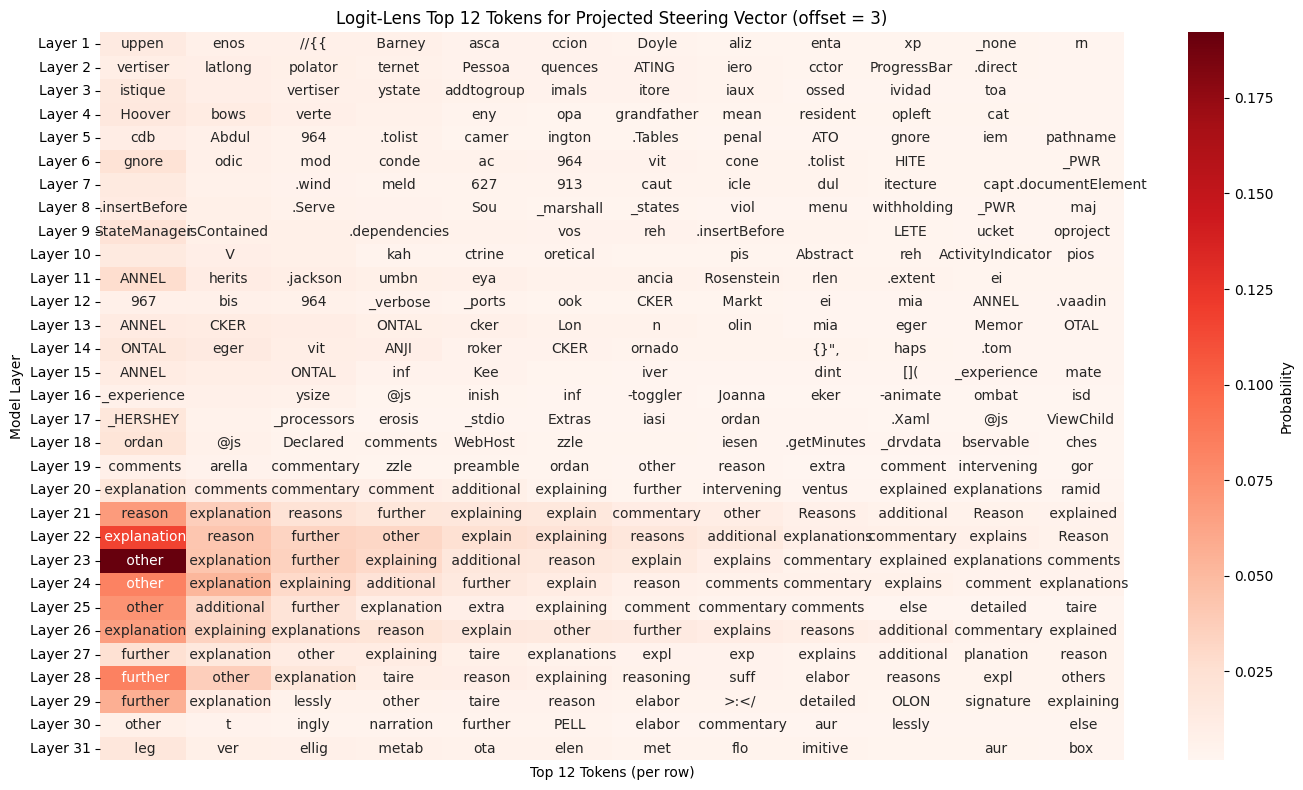

<ipython-input-122-0da94c21bf4d>:68: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


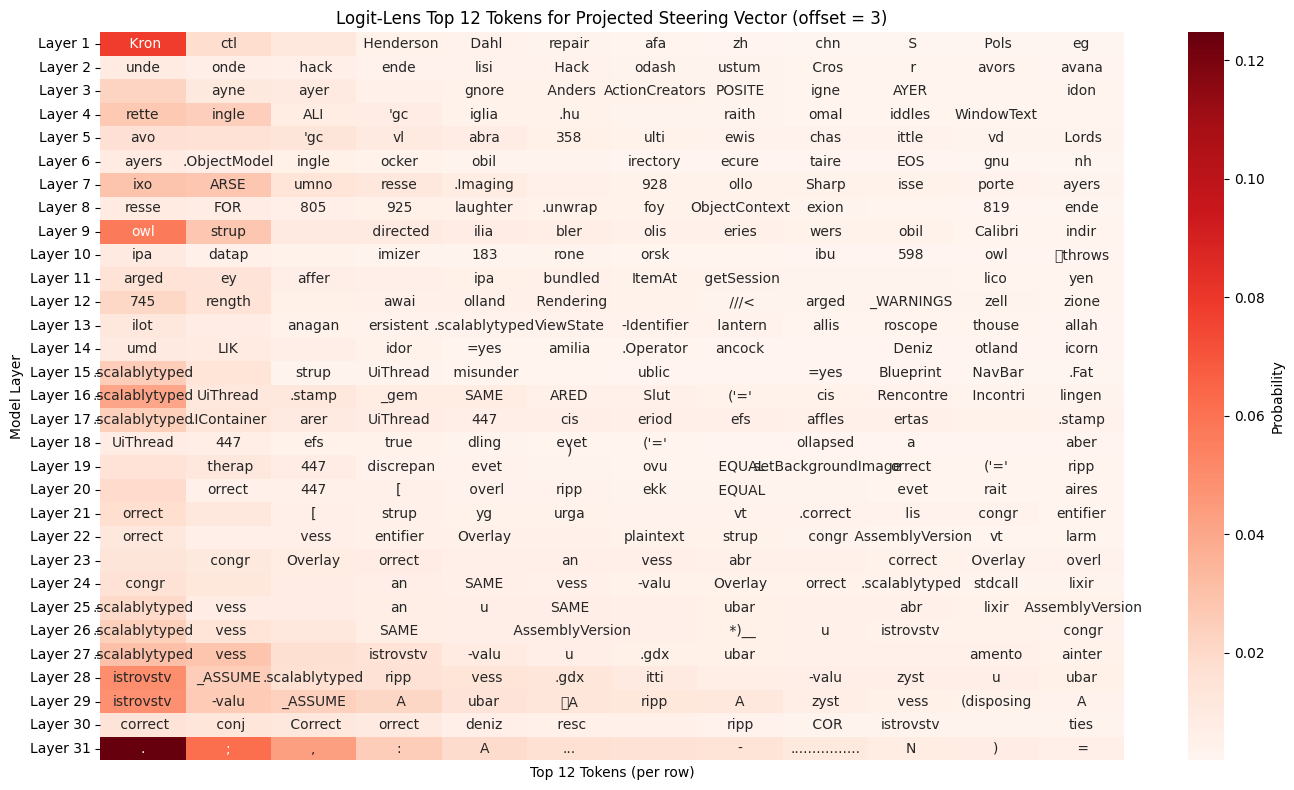

In [130]:
chosen_offset = 3  # e.g. 4th‐from‐last token
map_logit_lens_projected(
    layer_proj=projected_vectors_by_layer,
    model=model,
    tokenizer=tok,                   # pass your tokenizer here
    position=chosen_offset,
    top_k=12,
    suffix=f" (offset = {chosen_offset})"
)
map_logit_lens_projected(
    layer_proj=loaded_proj_with_nuissance,
    model=model,
    tokenizer=tok,                   # pass your tokenizer here
    position=chosen_offset,
    top_k=12,
    suffix=f" (offset = {chosen_offset})"
)



Keys (layers) in projected_vectors_by_layer: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Number of offsets in layer 1: 10
Loaded-offsets-with-nuisance layers (0-based): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Offsets per layer example (layer 0): 10
Loaded-proj-offsets layers (0-based): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Offsets per layer example (layer 0): 10
Layers for average nuisance: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


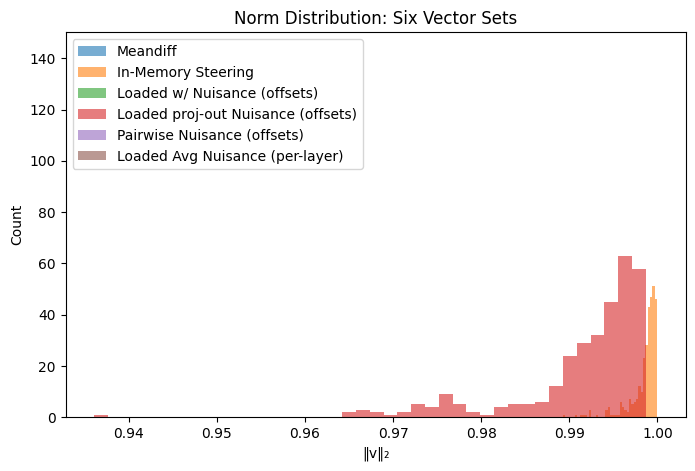

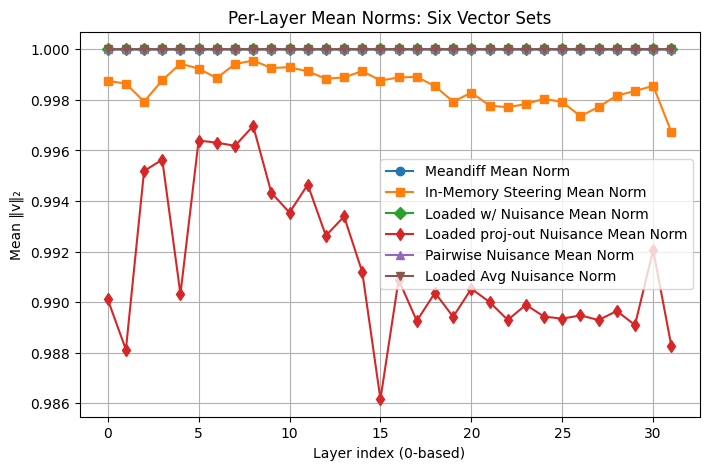

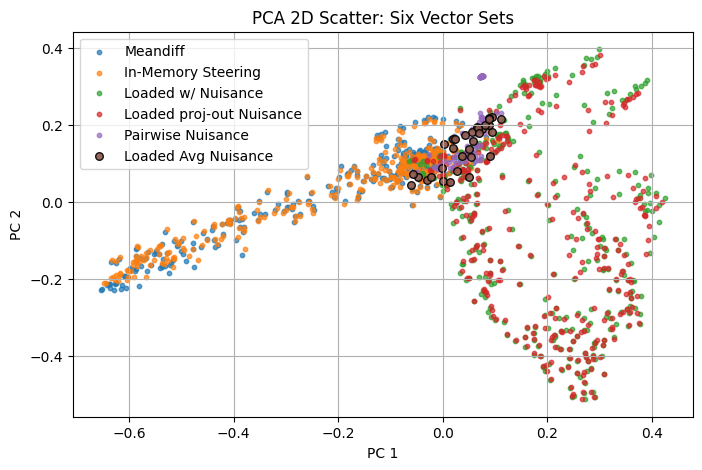

Average within-group cosines:
  Meandiff:                      0.109
  In-Memory Steering:            0.109
  Loaded w/ Nuisance (offsets):  0.115
  Loaded proj-out Nuisance:      0.113
  Pairwise Nuisance (offsets):   0.180
  Loaded Avg Nuisance (per-layer): 0.188

Average cross-group cosines:
  Meandiff vs In-Memory Steering: 0.111
  Meandiff vs Loaded w/ Nuisance: 0.017
  Meandiff vs Loaded proj-out Nuisance: 0.016
  Meandiff vs Pairwise Nuisance: 0.000
  Meandiff vs Loaded Avg Nuisance: 0.006
  In-Memory Steering vs Loaded w/ Nuisance: 0.017
  In-Memory Steering vs Loaded proj-out Nuisance: 0.016
  In-Memory Steering vs Pairwise Nuisance: -0.002
  In-Memory Steering vs Loaded Avg Nuisance: 0.006
  Loaded w/ Nuisance vs Loaded proj-out Nuisance: 0.116
  Loaded w/ Nuisance vs Pairwise Nuisance: 0.006
  Loaded w/ Nuisance vs Loaded Avg Nuisance: 0.027
  Loaded proj-out Nuisance vs Pairwise Nuisance: 0.005
  Loaded proj-out Nuisance vs Loaded Avg Nuisance: 0.008
  Pairwise Nuisance vs 

In [131]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# ─── 0. LOAD ALL STEERING-VECTOR SETS ─────────────────────────────────────────────

# (A) In-memory steering vectors (already computed elsewhere in your script)
#     We assume `projected_vectors_by_layer` is defined before this block.
print(f"Keys (layers) in projected_vectors_by_layer: {sorted(projected_vectors_by_layer.keys())}")
print(f"Number of offsets in layer 1: {len(projected_vectors_by_layer[1])}")

# (B) Loaded steering vectors “with nuisance” (original pickle: per-offset)
with open('steering_vectors_newbalancedtask3_meandiff.pkl', 'rb') as f:
    loaded_offsets_with_nuisance = pickle.load(f)
print("Loaded-offsets-with-nuisance layers (0-based):", sorted(loaded_offsets_with_nuisance.keys()))
print("Offsets per layer example (layer 0):", len(loaded_offsets_with_nuisance[0]))

# (C) Loaded steering vectors “projected-out nuisance” (new pickle: per-offset)
with open('steering_vectors_newbalancedtask3_meandiff_projectoutnuisance.pkl', 'rb') as f:
    loaded_proj = pickle.load(f)
print("Loaded-proj-offsets layers (0-based):", sorted(loaded_proj.keys()))
print("Offsets per layer example (layer 0):", len(loaded_proj[0]))


# ─── 0.5 COMPUTE AVERAGE NUISANCE VECTOR PER LAYER (from loaded offsets) ───────────

loaded_avg_nuisance = {}
for layer in sorted(loaded_offsets_with_nuisance.keys()):
    diffs = []
    for i in range(len(loaded_offsets_with_nuisance[layer])):
        w = loaded_offsets_with_nuisance[layer][i].numpy()
        p = loaded_proj[layer][i].numpy()
        diffs.append(w - p)               # this is the nuisance component for offset i

    diffs = np.vstack(diffs)             # shape (K, hidden)
    avg_nuis = diffs.mean(axis=0)        # average difference across offsets
    avg_nuis = avg_nuis / np.linalg.norm(avg_nuis)
    loaded_avg_nuisance[layer] = avg_nuis  # unit‐norm nuisance for this layer

print("Layers for average nuisance:", sorted(loaded_avg_nuisance.keys()))


# ─── 1. CONVERT ALL VECTORS TO NUMPY ARRAYS ───────────────────────────────────────

# 1A. Mean-diff: layer_diffs[ℓ] → list of length K Tensors
meandiff_np_list = [v.numpy() for vs in layer_diffs.values() for v in vs]        # 320 × hidden

# 1B. In-memory steering (residual) from projected_vectors_by_layer
steering_np_list = [v.numpy() for vs in projected_vectors_by_layer.values() for v in vs]  # 320 × hidden

# 1C. Loaded-with-nuisance offsets (original pickle)
loaded_wn_np_list = [v.numpy() for vs in loaded_offsets_with_nuisance.values() for v in vs]  # 320 × hidden

# 1D. Loaded-proj offsets (project-out-nuisance pickle)
loaded_proj_np_list = [v.numpy() for vs in loaded_proj.values() for v in vs]                # 320 × hidden

# 1E. Pairwise nuisance offsets: pairwise_nuisance[ℓ] may have M vectors per layer
nuisance_np_list = [v.numpy() for vs in pairwise_nuisance.values() for v in vs]             # (~480) × hidden

# 1F. Loaded-average-nuisance: one vector per layer
loaded_avg_nuis_np_list = [vec for layer, vec in sorted(loaded_avg_nuisance.items())]       # 32 × hidden

# Stack into matrices
meandiff_mat         = np.vstack(meandiff_np_list)       # (320, hidden)
steering_mat         = np.vstack(steering_np_list)       # (320, hidden)
loaded_wn_mat        = np.vstack(loaded_wn_np_list)      # (320, hidden)
loaded_proj_mat      = np.vstack(loaded_proj_np_list)    # (320, hidden)
pairwise_nuis_mat    = np.vstack(nuisance_np_list)       # (~480, hidden)
loaded_avg_nuis_mat  = np.vstack(loaded_avg_nuis_np_list)  # (32, hidden)


# ─── 2. NORM HISTOGRAMS FOR EACH SET ─────────────────────────────────────────────

meandiff_norms     = np.linalg.norm(meandiff_mat, axis=1)
steering_norms     = np.linalg.norm(steering_mat, axis=1)
loaded_wn_norms    = np.linalg.norm(loaded_wn_mat, axis=1)
loaded_proj_norms  = np.linalg.norm(loaded_proj_mat, axis=1)
pairwise_nu_norms  = np.linalg.norm(pairwise_nuis_mat, axis=1)
loaded_avg_nu_norms = np.linalg.norm(loaded_avg_nuis_mat, axis=1)

plt.figure(figsize=(8, 5))
plt.hist(meandiff_norms,      bins=40, alpha=0.6, label="Meandiff")
plt.hist(steering_norms,      bins=40, alpha=0.6, label="In-Memory Steering")
plt.hist(loaded_wn_norms,     bins=40, alpha=0.6, label="Loaded w/ Nuisance (offsets)")
plt.hist(loaded_proj_norms,   bins=40, alpha=0.6, label="Loaded proj-out Nuisance (offsets)")
plt.hist(pairwise_nu_norms,   bins=40, alpha=0.6, label="Pairwise Nuisance (offsets)")
plt.hist(loaded_avg_nu_norms, bins=40, alpha=0.6, label="Loaded Avg Nuisance (per-layer)")
plt.title("Norm Distribution: Six Vector Sets")
plt.xlabel("‖v‖₂")
plt.ylabel("Count")
plt.legend()
plt.show()


# ─── 3. PER-LAYER MEAN NORMS ─────────────────────────────────────────────────────

num_layers = len(layer_diffs)      # should be 32
K = len(next(iter(layer_diffs.values())))  # should be 10

# 3A. Meandiff norms per layer × offset
meandiff_norms_per_layer = np.zeros((num_layers, K))
for i, ℓ in enumerate(sorted(layer_diffs.keys())):
    for j, v in enumerate(layer_diffs[ℓ]):
        meandiff_norms_per_layer[i, j] = np.linalg.norm(v.numpy())

# 3B. In-memory steering norms per layer × offset
steering_norms_per_layer = np.zeros((num_layers, K))
for i, ℓ in enumerate(sorted(projected_vectors_by_layer.keys())):
    for j, v in enumerate(projected_vectors_by_layer[ℓ]):
        steering_norms_per_layer[i, j] = np.linalg.norm(v.numpy())

# 3C. Loaded-with-nuisance norms per layer × offset
loaded_wn_norms_per_layer = np.zeros((num_layers, K))
for i, ℓ in enumerate(sorted(loaded_offsets_with_nuisance.keys())):
    for j, v in enumerate(loaded_offsets_with_nuisance[ℓ]):
        loaded_wn_norms_per_layer[i, j] = np.linalg.norm(v.numpy())

# 3D. Loaded-proj (project-out-nuisance) norms per layer × offset
loaded_proj_norms_per_layer = np.zeros((num_layers, K))
for i, ℓ in enumerate(sorted(loaded_proj.keys())):
    for j, v in enumerate(loaded_proj[ℓ]):
        loaded_proj_norms_per_layer[i, j] = np.linalg.norm(v.numpy())

# 3E. Pairwise nuisance mean norm per layer (variable # per layer)
pairwise_nu_norms_per_layer = np.zeros(num_layers)
for i, ℓ in enumerate(sorted(pairwise_nuisance.keys())):
    nu_norms = [np.linalg.norm(v.numpy()) for v in pairwise_nuisance[ℓ]]
    pairwise_nu_norms_per_layer[i] = np.mean(nu_norms)

# 3F. Loaded-average-nuisance norm per layer (single value per layer)
loaded_avg_nu_norms_per_layer = np.zeros(num_layers)
for i, ℓ in enumerate(sorted(loaded_avg_nuisance.keys())):
    loaded_avg_nu_norms_per_layer[i] = np.linalg.norm(loaded_avg_nuisance[ℓ])

# Plot per-layer mean norms
layers = np.arange(num_layers)
plt.figure(figsize=(8, 5))
plt.plot(layers, meandiff_norms_per_layer.mean(axis=1),    marker='o', label='Meandiff Mean Norm')
plt.plot(layers, steering_norms_per_layer.mean(axis=1),    marker='s', label='In-Memory Steering Mean Norm')
plt.plot(layers, loaded_wn_norms_per_layer.mean(axis=1),   marker='D', label='Loaded w/ Nuisance Mean Norm')
plt.plot(layers, loaded_proj_norms_per_layer.mean(axis=1), marker='d', label='Loaded proj-out Nuisance Mean Norm')
plt.plot(layers, pairwise_nu_norms_per_layer,               marker='^', label='Pairwise Nuisance Mean Norm')
plt.plot(layers, loaded_avg_nu_norms_per_layer,             marker='v', label='Loaded Avg Nuisance Norm')
plt.title("Per-Layer Mean Norms: Six Vector Sets")
plt.xlabel("Layer index (0-based)")
plt.ylabel("Mean ‖v‖₂")
plt.legend()
plt.grid(True)
plt.show()


# ─── 4. PCA 2D SCATTER FOR ALL VECTORS ────────────────────────────────────────────

all_mat = np.vstack([
    meandiff_mat,
    steering_mat,
    loaded_wn_mat,
    loaded_proj_mat,
    pairwise_nuis_mat,
    loaded_avg_nuis_mat
])
pca = PCA(n_components=2)
coords = pca.fit_transform(all_mat)  # shape (N_total, 2)

# Split back into groups
n1 = meandiff_mat.shape[0]
n2 = steering_mat.shape[0]
n3 = loaded_wn_mat.shape[0]
n4 = loaded_proj_mat.shape[0]
n5 = pairwise_nuis_mat.shape[0]
n6 = loaded_avg_nuis_mat.shape[0]

coords_meandiff      = coords[:n1]
coords_steering      = coords[n1:n1+n2]
coords_loaded_wn     = coords[n1+n2:n1+n2+n3]
coords_loaded_pr     = coords[n1+n2+n3:n1+n2+n3+n4]
coords_pairwise_nu   = coords[n1+n2+n3+n4:n1+n2+n3+n4+n5]
coords_loaded_avg_nu = coords[-n6:]

plt.figure(figsize=(8, 5))
plt.scatter(coords_meandiff[:, 0],      coords_meandiff[:, 1],      s=10, label='Meandiff', alpha=0.7)
plt.scatter(coords_steering[:, 0],      coords_steering[:, 1],      s=10, label='In-Memory Steering', alpha=0.7)
plt.scatter(coords_loaded_wn[:, 0],     coords_loaded_wn[:, 1],     s=10, label='Loaded w/ Nuisance', alpha=0.7)
plt.scatter(coords_loaded_pr[:, 0],     coords_loaded_pr[:, 1],     s=10, label='Loaded proj-out Nuisance', alpha=0.7)
plt.scatter(coords_pairwise_nu[:, 0],   coords_pairwise_nu[:, 1],   s=10, label='Pairwise Nuisance', alpha=0.7)
plt.scatter(coords_loaded_avg_nu[:, 0], coords_loaded_avg_nu[:, 1], s=30, label='Loaded Avg Nuisance', alpha=0.9, edgecolors='k')
plt.title("PCA 2D Scatter: Six Vector Sets")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(True)
plt.show()


# ─── 5. COSINE SIMILARITY ANALYSIS ───────────────────────────────────────────────

# 5A. Within-group average cosine for each of the six sets
cos_md    = cosine_similarity(meandiff_mat)
avg_cos_md = np.mean(cos_md[np.triu_indices_from(cos_md, k=1)])

cos_st    = cosine_similarity(steering_mat)
avg_cos_st = np.mean(cos_st[np.triu_indices_from(cos_st, k=1)])

cos_wn    = cosine_similarity(loaded_wn_mat)
avg_cos_wn = np.mean(cos_wn[np.triu_indices_from(cos_wn, k=1)])

cos_pr    = cosine_similarity(loaded_proj_mat)
avg_cos_pr = np.mean(cos_pr[np.triu_indices_from(cos_pr, k=1)])

cos_pn    = cosine_similarity(pairwise_nuis_mat)
avg_cos_pn = np.mean(cos_pn[np.triu_indices_from(cos_pn, k=1)])

cos_an    = cosine_similarity(loaded_avg_nuis_mat)
avg_cos_an = np.mean(cos_an[np.triu_indices_from(cos_an, k=1)])

print("Average within-group cosines:")
print(f"  Meandiff:                      {avg_cos_md:.3f}")
print(f"  In-Memory Steering:            {avg_cos_st:.3f}")
print(f"  Loaded w/ Nuisance (offsets):  {avg_cos_wn:.3f}")
print(f"  Loaded proj-out Nuisance:      {avg_cos_pr:.3f}")
print(f"  Pairwise Nuisance (offsets):   {avg_cos_pn:.3f}")
print(f"  Loaded Avg Nuisance (per-layer): {avg_cos_an:.3f}\n")

# 5B. Between-group average cosines
def avg_cross_cos(matA, matB):
    return float(np.mean(cosine_similarity(matA, matB)))

pairs = [
    ("Meandiff", meandiff_mat, "In-Memory Steering", steering_mat),
    ("Meandiff", meandiff_mat, "Loaded w/ Nuisance", loaded_wn_mat),
    ("Meandiff", meandiff_mat, "Loaded proj-out Nuisance", loaded_proj_mat),
    ("Meandiff", meandiff_mat, "Pairwise Nuisance", pairwise_nuis_mat),
    ("Meandiff", meandiff_mat, "Loaded Avg Nuisance", loaded_avg_nuis_mat),
    ("In-Memory Steering", steering_mat, "Loaded w/ Nuisance", loaded_wn_mat),
    ("In-Memory Steering", steering_mat, "Loaded proj-out Nuisance", loaded_proj_mat),
    ("In-Memory Steering", steering_mat, "Pairwise Nuisance", pairwise_nuis_mat),
    ("In-Memory Steering", steering_mat, "Loaded Avg Nuisance", loaded_avg_nuis_mat),
    ("Loaded w/ Nuisance", loaded_wn_mat, "Loaded proj-out Nuisance", loaded_proj_mat),
    ("Loaded w/ Nuisance", loaded_wn_mat, "Pairwise Nuisance", pairwise_nuis_mat),
    ("Loaded w/ Nuisance", loaded_wn_mat, "Loaded Avg Nuisance", loaded_avg_nuis_mat),
    ("Loaded proj-out Nuisance", loaded_proj_mat, "Pairwise Nuisance", pairwise_nuis_mat),
    ("Loaded proj-out Nuisance", loaded_proj_mat, "Loaded Avg Nuisance", loaded_avg_nuis_mat),
    ("Pairwise Nuisance", pairwise_nuis_mat, "Loaded Avg Nuisance", loaded_avg_nuis_mat),
]

print("Average cross-group cosines:")
for nameA, matA, nameB, matB in pairs:
    print(f"  {nameA} vs {nameB}: {avg_cross_cos(matA, matB):.3f}")
